# A biophysical spiking network model, trained on MINST

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
from itertools import chain
import pickle
import time

import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
from jax.scipy.special import logsumexp

import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import jaxley as jx
from jaxley.channels import HH
from jaxley.channels import CaL, CaT, K, Km, Leak, Na
from jaxley.synapses import IonotropicSynapse, TanhRateSynapse
from jaxley.optimize.utils import l2_norm
from jaxley.connect import fully_connect, connect, sparse_connect

In [4]:
dales_law = False
comp_length = 40

i_amp_factor = comp_length / 10 

scale_readout_receptive_strength = 8

soma_radius = 10
soma_length = 2 * soma_radius

In [5]:
dt = 0.025
t_max = 10.01
time_vec = np.arange(0, t_max+2*dt, dt)
checkpoints = [int(np.ceil(np.sqrt(len(time_vec)))),
               int(np.ceil(np.sqrt(len(time_vec))))]

i_delay = 0.1
i_dur = 1.0
cols = [
    "#f0f0f0",
    "#d9d9d9",
    "#bdbdbd",
    "#969696",
    "#737373",
    "#525252",
    "#252525",
    "#000000",
]

In [6]:
checkpoints

[21, 21]

### Load training data

In [7]:
with open("../results/mnist_data.pickle", "rb") as handle:
    mnist = pickle.load(handle)

train = mnist["train"]
test = mnist["test"]

In [8]:
# Jaxley specific
pos_voltage = -90.0
neg_voltage = -50.0

def image_voltage_label(dataset):
    
    train_images = np.reshape(np.squeeze(dataset["image"]), (-1, 28**2)) / 255.0
    train_labels = dataset["label"]
    
    # Cast to JAX
    train_images = jnp.asarray(train_images)
    train_labels = jnp.asarray(train_labels)

    return train_images, train_labels

train_images, train_labels = image_voltage_label(train)
test_images, test_labels = image_voltage_label(test)

### Build network

In [9]:
fnames = os.listdir("../morphologies/")
fnames = [f for f in fnames if f.startswith("n")]
fnames = [f"morphologies/{f}/{f}.CNG.swc" for f in fnames]

In [10]:
# hardcoding fnames here because os.listdir can return files in different order depending on the filesystem
# this order is consistent with the checkpoints that we already evaluated
# if starting from scratch, simply sorted(os.listdir) will do the job
fnames = ['../morphologies/n171/n171.CNG.swc',
         '../morphologies/n174/n174.CNG.swc',
         '../morphologies/n130/n130.CNG.swc',
         '../morphologies/n400/n400.CNG.swc',
         '../morphologies/n404/n404.CNG.swc',
         '../morphologies/n140/n140.CNG.swc',
         '../morphologies/n127/n127.CNG.swc',
         '../morphologies/n122/n122.CNG.swc',
         '../morphologies/n412/n412.CNG.swc',
         '../morphologies/n125/n125.CNG.swc',
         '../morphologies/n403/n403.CNG.swc',
         '../morphologies/n420/n420.CNG.swc',
         '../morphologies/n407/n407.CNG.swc',
         '../morphologies/n417/n417.CNG.swc',
         '../morphologies/n144/n144.CNG.swc',
         '../morphologies/n141/n141.CNG.swc',
         '../morphologies/n145/n145.CNG.swc',
         '../morphologies/n410/n410.CNG.swc',
         '../morphologies/n129/n129.CNG.swc',
         '../morphologies/n416/n416.CNG.swc',
         '../morphologies/n414/n414.CNG.swc',
         '../morphologies/n408/n408.CNG.swc',
         '../morphologies/n142/n142.CNG.swc',
         '../morphologies/n406/n406.CNG.swc',
         '../morphologies/n179/n179.CNG.swc',
         '../morphologies/n177/n177.CNG.swc',
         '../morphologies/n411/n411.CNG.swc',
         '../morphologies/n181/n181.CNG.swc',
         '../morphologies/n184/n184.CNG.swc',
         '../morphologies/n402/n402.CNG.swc',
         '../morphologies/n176/n176.CNG.swc',
         '../morphologies/n409/n409.CNG.swc',
         '../morphologies/n415/n415.CNG.swc',
         '../morphologies/n422/n422.CNG.swc',
         '../morphologies/n123/n123.CNG.swc',
         '../morphologies/n121/n121.CNG.swc',
         '../morphologies/n401/n401.CNG.swc',
         '../morphologies/n128/n128.CNG.swc',
         '../morphologies/n421/n421.CNG.swc',
         '../morphologies/n418/n418.CNG.swc',
         '../morphologies/n126/n126.CNG.swc',
         '../morphologies/n172/n172.CNG.swc',
         '../morphologies/n413/n413.CNG.swc',
         '../morphologies/n170/n170.CNG.swc',
         '../morphologies/n175/n175.CNG.swc',
         '../morphologies/n178/n178.CNG.swc',
         '../morphologies/n173/n173.CNG.swc',
         '../morphologies/n405/n405.CNG.swc',
         '../morphologies/n183/n183.CNG.swc',
         '../morphologies/n143/n143.CNG.swc',
         '../morphologies/n180/n180.CNG.swc',
         '../morphologies/n419/n419.CNG.swc',
         '../morphologies/n120/n120.CNG.swc',
         '../morphologies/n423/n423.CNG.swc',
         '../morphologies/n182/n182.CNG.swc']

In [11]:
nseg = 4  # original: 4

comp = jx.Compartment()
branch = jx.Branch(comp, nseg)
input_cell = jx.Cell(branch, [-1])

# Dendrites.
input_cell[0, 1:nseg].set("length", comp_length)
input_cell[0, 1:nseg].set("radius", 1.0)

input_cell[0, 0].set("length", soma_length)
input_cell[0, 0].set("radius", soma_radius)

input_neurons = [input_cell for _ in range(28**2)]

morph_cells = [jx.read_swc(fname, nseg=4) for fname in fnames]
# morph_cells = [jx.read_swc(fname, nseg=2) for fname in fnames]

# hidden_cell = jx.Cell(branch, [-1, 0, 0])
hidden_neurons = [morph_cells[i % len(morph_cells)] for i in range(64)]

output_cell = jx.Cell(branch, [-1])

output_cell[0, 1:nseg].set("length", comp_length)
output_cell[0, 1:nseg].set("radius", 1.0)

output_cell[0, 0].set("length", soma_length)
output_cell[0, 0].set("radius", soma_radius)

output_neurons = [output_cell for _ in range(10)]

all_neurons = input_neurons + hidden_neurons + output_neurons
net = jx.Network(all_neurons)


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:140: UserWarning: `num_subbranches > 10`, stopping to split. Most likely your
                     SWC reconstruction is not dense and some neighbouring traced
                     points are farther than `max_branch_len` apart.
  warn(


### Define layers of cells and split into exc and inh

In [12]:
def get_non_selected_indices(a, b, selected_indices):
    all_indices = np.arange(a, b)
    non_selected_indices = np.setdiff1d(all_indices, selected_indices)
    return non_selected_indices

In [13]:
_ = np.random.seed(4)

layer_inds = [0, 28**2, 28**2 + 64]  # , 28**2 + 64 + 2]

exc_frac = 0.75

for layer in range(len(layer_inds) - 1):
    num = layer_inds[layer + 1] - layer_inds[layer]
    a = layer_inds[layer]
    b = layer_inds[layer+1]
    exc_neuron_inds = np.random.choice(np.arange(a, b), (int(num * exc_frac)), replace=False)
    inh_neuron_inds = get_non_selected_indices(a, b, exc_neuron_inds)

    net.cell(exc_neuron_inds.tolist()).add_to_group(f"layer{layer}_exc")
    net.cell(inh_neuron_inds.tolist()).add_to_group(f"layer{layer}_inh")

net.cell(np.arange(28**2).tolist()).add_to_group("layer0")
net.cell(np.arange(28**2, 28**2+64).tolist()).add_to_group("layer1")
net.cell(np.arange(28**2+64, 28**2+64+10).tolist()).add_to_group("layer2")

In [14]:
net.cell

CellView. Use `.show()` for details.

### Insert cellular mechanisms

In [15]:
net.layer0.insert(HH())
net.layer1.insert(HH())
net.layer2.insert(Leak())
net.set("axial_resistivity", 100.0)

### Insert synapses

In [16]:
_ = np.random.seed(5)

pre = net.layer0_exc.cell("all")
post = net.layer1.cell("all")
fully_connect(pre, post, IonotropicSynapse().change_name("Conns1_exc"))

pre = net.layer0_inh.cell("all")
post = net.layer1.cell("all")
fully_connect(pre, post, IonotropicSynapse().change_name("Conns1_inh"))

pre = net.layer1_exc.cell("all")
post = net.layer2.cell("all")
fully_connect(pre, post, IonotropicSynapse().change_name("Conns2_exc"))

pre = net.layer1_inh.cell("all")
post = net.layer2.cell("all")
fully_connect(pre, post, IonotropicSynapse().change_name("Conns2_inh"))

In [17]:
_ = np.random.seed(0) #2)  # 2, 8

if dales_law:
    w1_exc = np.abs(np.random.randn(len(net.Conns1_exc.view)) / 28**2)
    w1_inh = np.abs(np.random.randn(len(net.Conns1_inh.view)) / 28**2)
    w2_exc = np.abs(np.random.randn(len(net.Conns2_exc.view)) / 64)
    w2_inh = np.abs(np.random.randn(len(net.Conns2_inh.view)) / 64)
    
    # Weaker synapses in the second layer (because we project on non-spiking neurons)
    w1_exc /= 25.0
    w1_inh /= 25.0
    w2_exc /= 2_500.0
    w2_inh /= 2_500.0
    
    # Inhibitory synapses should be stronger.
    w1_exc *= 1.0
    w1_inh *= 5.0
    w2_exc *= 1.0 * i_amp_factor
    w2_inh *= 5.0 * i_amp_factor
    
    net.Conns1_exc("all").set("Conns1_exc_gS", w1_exc)
    net.Conns1_inh("all").set("Conns1_inh_gS", w1_inh)
    net.Conns2_exc("all").set("Conns2_exc_gS", w2_exc)
    net.Conns2_inh("all").set("Conns2_inh_gS", w2_inh)
    
    e_syn_exc = 0.0
    e_syn_inh = -100.0
    net.Conns1_exc("all").set("Conns1_exc_e_syn", e_syn_exc)
    net.Conns1_inh("all").set("Conns1_inh_e_syn", e_syn_inh)
    net.Conns2_exc("all").set("Conns2_exc_e_syn", e_syn_exc)
    net.Conns2_inh("all").set("Conns2_inh_e_syn", e_syn_inh)
else:
    w1_exc = np.random.randn(len(net.Conns1_exc.view)) / 28**2
    w1_inh = np.random.randn(len(net.Conns1_inh.view)) / 28**2
    w2_exc = np.random.randn(len(net.Conns2_exc.view)) / 64
    w2_inh = np.random.randn(len(net.Conns2_inh.view)) / 64
    
    # Weaker synapses in the second layer (because we project on non-spiking neurons)
    w1_exc /= 25.0
    w1_inh /= 25.0
    w2_exc /= 25.0
    w2_inh /= 25.0
    
    # Inhibitory synapses should be stronger.
    w1_exc *= 1.0
    w1_inh *= 1.0
    w2_exc *= 1.0 * i_amp_factor / scale_readout_receptive_strength
    w2_inh *= 1.0 * i_amp_factor / scale_readout_receptive_strength
    
    net.Conns1_exc("all").set("Conns1_exc_gS", w1_exc)
    net.Conns1_inh("all").set("Conns1_inh_gS", w1_inh)
    net.Conns2_exc("all").set("Conns2_exc_gS", w2_exc)
    net.Conns2_inh("all").set("Conns2_inh_gS", w2_inh)

    
net.Conns1_exc("all").set("Conns1_exc_k_minus", 0.25)
net.Conns1_inh("all").set("Conns1_inh_k_minus", 0.25)
net.Conns2_exc("all").set("Conns2_exc_k_minus", 0.25)
net.Conns2_inh("all").set("Conns2_inh_k_minus", 0.25)

### Define simulation and loss

In [18]:
net.delete_recordings()
net.delete_stimuli()
net[:, 0, 0].record()

Added 858 recordings. See `.recordings` for details.


In [19]:
tau = 500.0
i_amp = i_amp_factor * 50.0 / tau

def simulate(params, image):
    currents = jx.datapoint_to_step_currents(i_delay, i_dur, i_amp*image, dt, t_max)
    data_stimuli = net[range(784), 0, nseg-1].data_stimulate(currents, None)
    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)

jitted_simulate = jit(simulate)
vmapped_simulate = jit(vmap(simulate, in_axes=(None, 0)))

In [20]:
def predict(params, image):
    vs = simulate(params, image)
    return vs[:, -1]

vmapped_predict = jit(vmap(predict, in_axes=(None, 0)))

In [21]:
def cross_entropy_loss(opt_params, image, label):
    params = transform.forward(opt_params)
    prediction = predict(params, image)
    prediction += 65.0
    prediction /= 3.0
    log_prob = prediction[label] - logsumexp(prediction)
    return -log_prob

vmapped_cross_entropy_loss = jit(vmap(cross_entropy_loss, in_axes=(None, 0, 0)))

In [22]:
def batch_loss(opt_params, image_batch, label_batch):
    losses = vmap(cross_entropy_loss, in_axes=(None, 0, 0))(opt_params, image_batch, label_batch)
    return jnp.mean(losses)

jitted_batch_loss = jit(batch_loss)
loss_grad = jit(value_and_grad(batch_loss, argnums=0))

In [23]:
def eval_cross_entropy_accuracy(opt_params, num_eval: int, train_or_test: str):
    if train_or_test == "train":
        images = train_images[:num_eval]
        labels = train_labels[:num_eval]
    elif train_or_test == "test":
        images = test_images[:num_eval]
        labels = test_labels[:num_eval]
    else:
        raise ValueError
    
    prediction = vmapped_predict(
        transform.forward(opt_params),
        images,
    )
    prediction = jnp.argmax(prediction, axis=1).astype(int)
    return np.mean(prediction == labels)

In [24]:
dales_law

False

In [25]:
safety_magin = 5.0

if dales_law:
    transform = jx.ParamTransform(
        lowers={
            "Conns1_exc_gS": 0.0, 
            "Conns1_inh_gS": 0.0, 
            "Conns2_exc_gS": 0.0, 
            "Conns2_inh_gS": 0.0, 
            "HH_gNa": 0.05, 
            "HH_gK": 0.01, 
            "HH_gLeak": 0.0001,
            "axial_resistivity": 30.0,
        },
        uppers={
            "Conns1_exc_gS": safety_magin / 28**2 / 25.0,
            "Conns1_inh_gS": safety_magin / 28**2 / 25.0 * 5.0,
            "Conns2_exc_gS": safety_magin / 64.0 / 2_500.0 * i_amp_factor,
            "Conns2_inh_gS": safety_magin / 64.0 / 2_500.0 * 5.0 * i_amp_factor,
            "HH_gNa": 0.5,
            "HH_gK": 0.1,
            "HH_gLeak": 0.001,
            "axial_resistivity": 1_000,
        },
    )
else:
    transform = jx.ParamTransform(
        lowers={
            "Conns1_exc_gS": - safety_magin / 28**2 / 25.0,
            "Conns1_inh_gS": - safety_magin / 28**2 / 25.0 ,
            "Conns2_exc_gS": - safety_magin / 64.0 / 25.0 * i_amp_factor / scale_readout_receptive_strength,
            "Conns2_inh_gS": - safety_magin / 64.0 / 25.0 * i_amp_factor / scale_readout_receptive_strength,
            "HH_gNa": 0.05, 
            "HH_gK": 0.01, 
            "HH_gLeak": 0.0001,
            "axial_resistivity": 30.0,
        },
        uppers={
            "Conns1_exc_gS": safety_magin / 28**2 / 25.0,
            "Conns1_inh_gS": safety_magin / 28**2 / 25.0 ,
            "Conns2_exc_gS": safety_magin / 64.0 / 25.0 * i_amp_factor / scale_readout_receptive_strength,
            "Conns2_inh_gS": safety_magin / 64.0 / 25.0 * i_amp_factor / scale_readout_receptive_strength,
            "HH_gNa": 0.5,
            "HH_gK": 0.1,
            "HH_gLeak": 0.001,
            "axial_resistivity": 1_000,
        },
    )

### Train

In [26]:
net.set("v", -65)
net.init_states()

In [27]:
net.delete_trainables()
net.Conns1_exc("all").make_trainable("Conns1_exc_gS")
net.Conns1_inh("all").make_trainable("Conns1_inh_gS")
net.Conns2_exc("all").make_trainable("Conns2_exc_gS")
net.Conns2_inh("all").make_trainable("Conns2_inh_gS")
net.cell("all").branch("all").make_trainable("HH_gNa")
net.cell("all").branch("all").make_trainable("HH_gK")
net.cell("all").branch("all").make_trainable("HH_gLeak")
net.cell("all").branch("all").make_trainable("axial_resistivity")
parameters = net.get_parameters()

Number of newly added trainable parameters: 37632. Total number of trainable parameters: 37632
Number of newly added trainable parameters: 12544. Total number of trainable parameters: 50176
Number of newly added trainable parameters: 480. Total number of trainable parameters: 50656
Number of newly added trainable parameters: 160. Total number of trainable parameters: 50816
Number of newly added trainable parameters: 13938. Total number of trainable parameters: 64754
Number of newly added trainable parameters: 13938. Total number of trainable parameters: 78692
Number of newly added trainable parameters: 13938. Total number of trainable parameters: 92630
Number of newly added trainable parameters: 13948. Total number of trainable parameters: 106578


In [28]:
len(parameters)

8

In [29]:
images = train_images[:4]
labels = train_labels[:4]
start_time = time.time()
voltages = vmapped_simulate(parameters, images)
print("Time: ", time.time() - start_time)
# pos_voltages = voltages[labels == 1]
# neg_voltages = voltages[labels == 0]

Time:  65.09575819969177


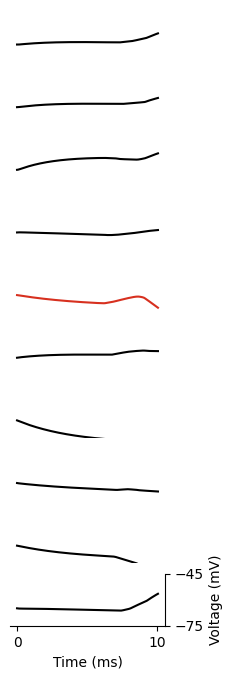

In [30]:
ind = 0

fig, ax = plt.subplots(10, 1, figsize=(2.0, 8.0))
for i in range(10):
    c = "#d7301f" if 9 - i == labels[ind] else "k"
    _ = ax[9-i].plot(time_vec, voltages[ind, -i-1, :].T, c=c)
    _ = ax[i].set_yticks([-75, -45.0])
    _ = ax[i].set_ylim([-75, -45.0])
    _ = ax[i].spines["top"].set_visible(False)
    _ = ax[i].spines["left"].set_visible(False)

for i in range(9):
    _ = ax[i].set_xticks([])
    _ = ax[i].set_yticks([])
    _ = ax[i].spines["right"].set_visible(False)
    _ = ax[i].spines["bottom"].set_visible(False)

_ = ax[-1].set_xticks([0, 10])
_ = ax[-1].set_xlabel("Time (ms)")
_ = ax[-1].set_ylabel("Voltage (mV)")
_ = ax[-1].yaxis.set_label_position("right")
_ = ax[-1].yaxis.set_ticks_position("right")

plt.show()

### Hidden layer

In [31]:
stims = jx.datapoint_to_step_currents(i_delay, i_dur, i_amp * images[0], dt, t_max)

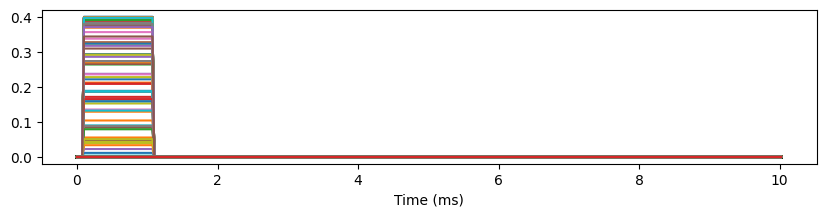

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10.0, 2.0))
_ = ax.plot(time_vec[:-1], stims.T)
_ = ax.set_xlabel("Time (ms)")
plt.show()

## Perform a few checks that the network is initialized in a healthy regime

### Input layer activations,...

In [34]:
#(nimages, nneurons, ntimesteps)
voltages.shape

(4, 858, 403)

In [36]:
def is_spike(voltages):
    layers = {}
    for i in range(len(layer_inds)-1):
        _voltages= voltages[:, layer_inds[i]:layer_inds[i+1]]
        layers[i] = np.any(_voltages>0, axis=2)
    return layers

def has_spike(voltages):
    s = is_spike(voltages)
    return all(v.sum()>0 for v in s.values())

def all_spike_hidden(voltages):
    s = is_spike(voltages)
    return s[1].sum() == s[1].size
    return all(v.sum()!=v.size for v in s.values())

In [37]:
assert has_spike(voltages)

In [38]:
batch, cell_id = np.where(is_spike(voltages)[0])

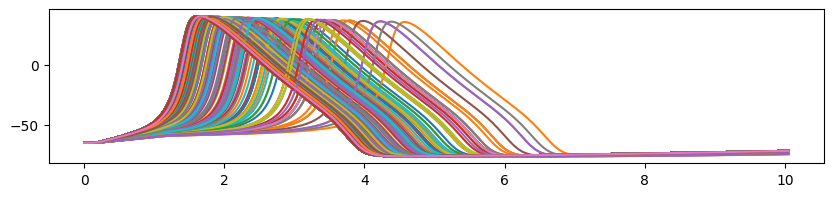

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10.0, 2.0))
for i, j in zip(batch, cell_id):
    _ = ax.plot(time_vec, voltages[i, j, :].T)

plt.show()

### ...hidden layer activations...

In [40]:
batch, cell_id = np.where(is_spike(voltages)[1])

In [41]:
assert not all_spike_hidden(voltages)

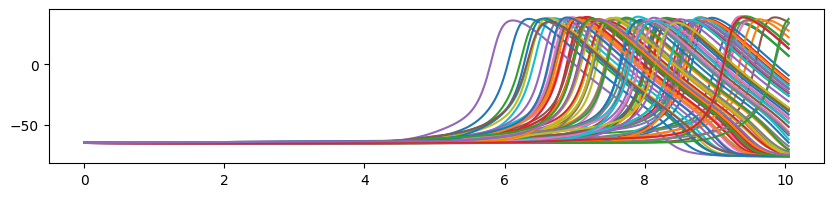

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10.0, 2.0))
for i, j in zip(batch, cell_id):
    _ = ax.plot(time_vec, voltages[i, j + is_spike(voltages)[0].shape[1], :].T)

plt.show()

### ...and output layer activations

In [43]:
def has_variance(voltages, thresh=0.5, output_slice=slice(-10, None, 1)):
    return np.std(voltages[:, output_slice, -1]) > thresh
    

In [44]:
assert has_variance(voltages)

In [45]:
output_slice=slice(-10, None, 1)

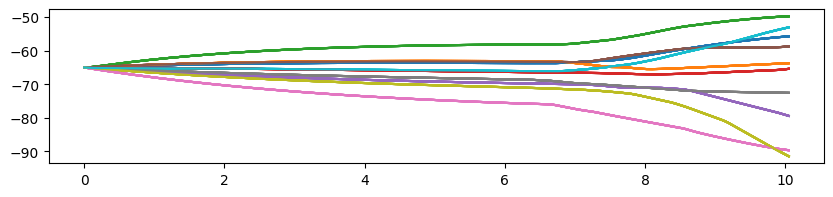

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10.0, 2.0))
for i in range(voltages.shape[1] - 10, voltages.shape[1]):
    _ = ax.plot(time_vec, voltages[3, output_slice, :].T)

plt.show()

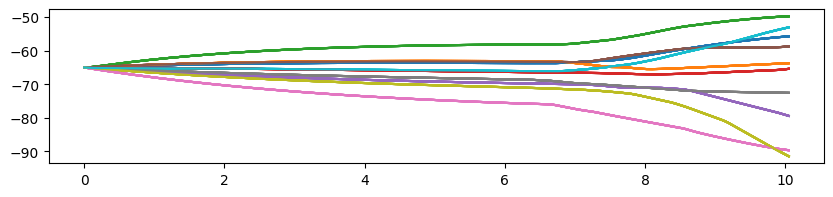

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10.0, 2.0))
for i in range(voltages.shape[1] - 10, voltages.shape[1]):
    _ = ax.plot(time_vec, voltages[3, output_slice, :].T)

plt.show()

## Train loop

In [181]:
from tqdm.auto import tqdm
from time import sleep
from pathlib import Path
from datamate import Directory, root
import json
import codecs
import json
from ipylab import JupyterFrontEnd

import logging

def strip_outputs(nb):
    for cell in nb['cells']:
        cell['outputs'] = []

results_dir = Path("results/parameters")
results_dir.mkdir(exist_ok=True, parents=True)

@root(results_dir)
class TrainingRun(Directory):
    def __init__(self, nb_file: dict):
        pass

def load_best_chkpt(directory: str):
    last_training_run = Directory(directory)
    chkpts = sorted([p for epoch in last_training_run.chkpts.path.iterdir() 
                     for p in epoch.iterdir() if epoch.name != '000' and p.name.startswith('opt_param')])
    assert len(chkpts) == len(last_training_run.test_acc[:])
    best = chkpts[np.argmax(last_training_run.test_acc[:])]
    with open(best, "rb") as handle:
      return pickle.load(handle)

# supposedly saving the notebook programatically before tracking it for the experiment, but couldn't confirm yet that it does
# https://stackoverflow.com/questions/66880698/how-to-cause-jupyter-lab-to-save-notebook-programmatically
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')


NB_FILE = Path("/mnt/janne/jaxley_experiments/nex/ca1net/08_spiking_EI_balance_morph_all_digits_janne.ipynb")

In [48]:
jitted_simulate = jit(simulate)
vmapped_simulate = jit(vmap(simulate, in_axes=(None, 0)))
vmapped_predict = jit(vmap(predict, in_axes=(None, 0)))
vmapped_cross_entropy_loss = jit(vmap(cross_entropy_loss, in_axes=(None, 0, 0)))
jitted_batch_loss = jit(batch_loss)
loss_grad = jit(value_and_grad(batch_loss, argnums=0))

### Set up

- Delete all recordings because we will then only record the output neurons  
- Delete all stimuli because they are injected via `data_stimulate()`.

In [50]:
net.delete_recordings()
net.delete_stimuli()
net[range(28**2+64, 28**2+64+10), 0, 0].record()

Added 10 recordings. See `.recordings` for details.


In [51]:
opt_params = transform.inverse(parameters)

assert np.all(np.invert(np.isnan(opt_params[0]["Conns1_exc_gS"])))
assert np.all(np.invert(np.isnan(opt_params[1]["Conns1_inh_gS"])))
assert np.all(np.invert(np.isnan(opt_params[2]["Conns2_exc_gS"])))
assert np.all(np.invert(np.isnan(opt_params[3]["Conns2_inh_gS"])))
assert np.all(np.invert(np.isnan(opt_params[4]["HH_gNa"])))
assert np.all(np.invert(np.isnan(opt_params[5]["HH_gK"])))
assert np.all(np.invert(np.isnan(opt_params[6]["HH_gLeak"])))
assert np.all(np.invert(np.isnan(opt_params[7]["axial_resistivity"])))

In [52]:
_ = np.random.seed(0)

num_train = 60_000
train_images_use = train_images[:num_train]
train_labels_use = train_labels[:num_train]

tf.random.set_seed(0)

batch_size = 16
dataloader = tf.data.Dataset.from_tensor_slices((train_images_use, train_labels_use))
dataloader = dataloader.shuffle(dataloader.cardinality()).batch(batch_size)

num_batches = num_train // batch_size
print(f"Number of batches {num_batches}")

Number of batches 3750


In [53]:
import jax

In [64]:
reduce_after_num_epochs = 10

n_epochs = 7

# finetuning 2: scheduling from 1e-8 to 1e-5 (twice the end value from before) and back with cosine
# the peak value might be a bit too high but lets see
alpha = 0.05
total_steps = num_batches * n_epochs

# rerun ohne dales law after solver fix
# define the schedules
schedule1 = optax.constant_schedule(1e-3)
schedule2 = optax.warmup_cosine_decay_schedule(
    init_value=1e-5,
    peak_value=5e-3,
    warmup_steps=int(num_batches * 0.25),
    decay_steps=int(num_batches * 5 - num_batches * 0.25),
    end_value=1e-3 * 1e-3,
    exponent=1.0,
)

# custom schedule function
def combined_schedule(step):
    switch_step = 2 * num_batches #int(num_batches * n_epochs * 0.5)  # for example, switch after half the steps
    return jax.lax.cond(step < switch_step,
                        lambda _: jnp.float32(schedule1(step)),
                        lambda _: jnp.float32(schedule2(step - 2 * num_batches)),
                        operand=None)

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=combined_schedule)
)

opt_state = optimizer.init(opt_params)

In [65]:
x = vmap(combined_schedule)(np.arange(num_batches * n_epochs))

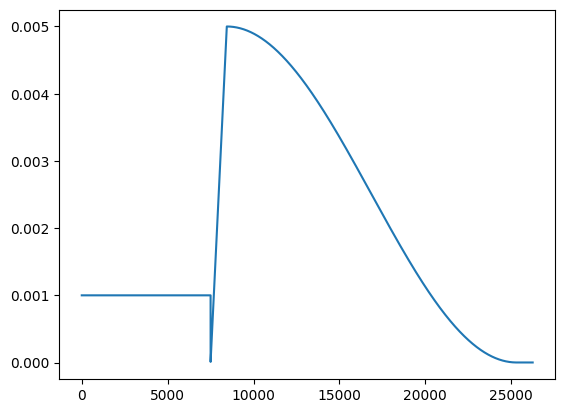

In [66]:
plt.plot(x)

In [ ]:
batch = next(iter(dataloader))
image_batch, label_batch = tfds.as_numpy(batch)
loss_val, gradient = loss_grad(opt_params, image_batch, label_batch)

2024-08-12 12:57:17.649307: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m1.057577351s

********************************
[Compiling module jit_batch_loss] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [ ]:
tf.random.set_seed(0)

best_acc = 0.0
best_loss = 1e12
broken = False


f=codecs.open(NB_FILE, 'r')
nb = json.loads(f.read())
strip_outputs(nb)
# this encodes the stripped notebook into the _meta.yaml without outputs
training_run_dir = TrainingRun(nb_file=nb) 

# this copies the entire notebook given the last checkpoint
training_run_dir[NB_FILE.name] = NB_FILE
print("Results stored at: ", training_run_dir.path)
logging.basicConfig(filename=training_run_dir.path / 'training.log', level=logging.INFO)

logging.info('Training started...')
epoch=0
i=0
(training_run_dir.path / "chkpts" / f"{epoch:03}").mkdir(exist_ok=True, parents=True)
with open(training_run_dir.path / "chkpts" / f"{epoch:03}" / f"opt_params_{i:04}", "wb") as handle:
    pickle.dump(opt_params, handle)
with open(training_run_dir.path / "chkpts" / f"{epoch:03}" / f"opt_state_{i:04}", "wb") as handle:
    pickle.dump(opt_state, handle)

loss_vals = []
for epoch in range(1, n_epochs+1):
    if broken:
        break
    epoch_loss = 0.0
    for i, batch in enumerate(tqdm(dataloader)):
        image_batch, label_batch = tfds.as_numpy(batch)
        loss_val, gradient = loss_grad(opt_params, image_batch, label_batch)
        
        loss_vals.append(loss_val)
        
        epoch_loss += loss_val

        loss_not_nan = np.invert(np.isnan(loss_val))

        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)

        if i % 300 == 0:
            print(f"{i} intermediate avg loss {epoch_loss / (i+1):.5f}")
            if loss_not_nan:
                (training_run_dir.path / "chkpts" / f"{epoch:03}").mkdir(exist_ok=True, parents=True)
                with open(training_run_dir.path / "chkpts" / f"{epoch:03}" / f"opt_params_{i:04}", "wb") as handle:
                    pickle.dump(opt_params, handle)
                with open(training_run_dir.path / "chkpts" / f"{epoch:03}" / f"opt_state_{i:04}", "wb") as handle:
                    pickle.dump(opt_state, handle)
                training_run_dir.loss = loss_vals
            else:
                broken = True
                break
            test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
            training_run_dir.extend("test_acc", [test_acc])
            print(f"Test acc ", f"{i}/{len(dataloader)}: ", f"{test_acc}")
    
    print(f"AVG Loss in epoch {epoch}/{n_epochs}: {epoch_loss / (i+1):.4f}")
    
# log very last result
if loss_not_nan:
    (training_run_dir.path / "chkpts" / f"{epoch:03}").mkdir(exist_ok=True, parents=True)
    with open(training_run_dir.path / "chkpts" / f"{epoch:03}" / f"opt_params_{i:04}", "wb") as handle:
        pickle.dump(opt_params, handle)
    with open(training_run_dir.path / "chkpts" / f"{epoch:03}" / f"opt_state_{i:04}", "wb") as handle:
        pickle.dump(opt_state, handle)
    training_run_dir.loss = loss_vals
else:
    broken = True
    break
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
training_run_dir.extend("test_acc", [test_acc])
print(f"Test acc ", f"{i}/{len(dataloader)}: ", f"{test_acc}")
logging.info('Training completed successfully.')


In [ ]:
test_acc = eval_cross_entropy_accuracy(opt_params, 1024, "test")
print(f"Final test acc: {test_acc}")